<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/10_Time_Series_Forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series-Forecasting-with-TensorFlow + MileStone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin

⚠️ **Note:** This is not a financial advice!!!

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future prices of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3342fe28-5ebe-c581-9bf7-24a39ff41521)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-24 14:50:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-06-24 14:50:10 (7.40 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Import TimeSeries with Pandas

In [3]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])    # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically, deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

Below is a table showcasing what would collecting one sample at different time frames result in:

1 sample per timeframe | Number of samples per year
---------------------- | --------------------------
Second | 31,536,000
Hour | 8,760
Day | 365
Week | 52
Month | 12

> 🔑 **Note:** The **seasonality** of a time series dataset is referred to as the number of samples per year. So, for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


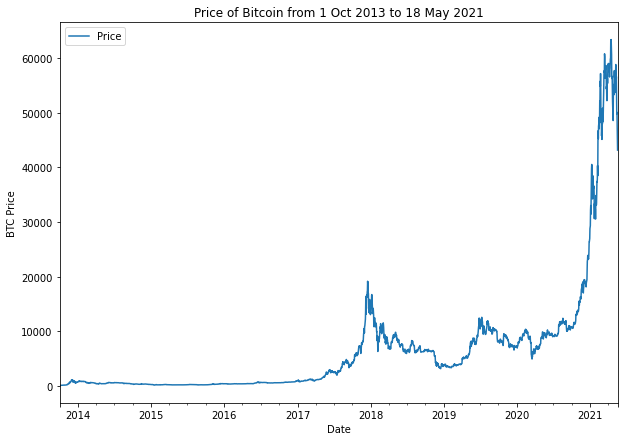

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.legend();

## Importing time series data with Python's CSV Module

In [9]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader)    # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))    # get the dates as dates (not strings)
        btc_price.append(float(line[2]))    # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

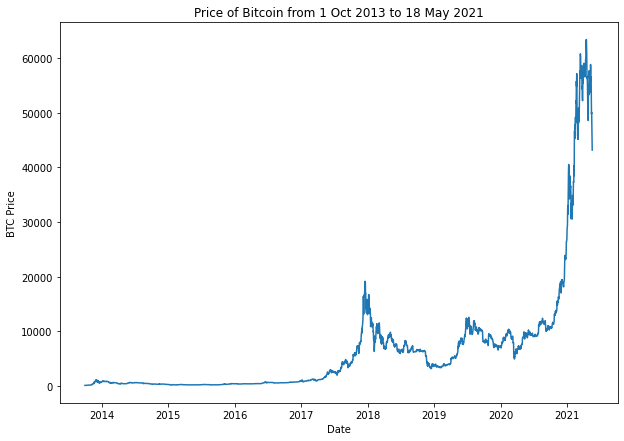

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

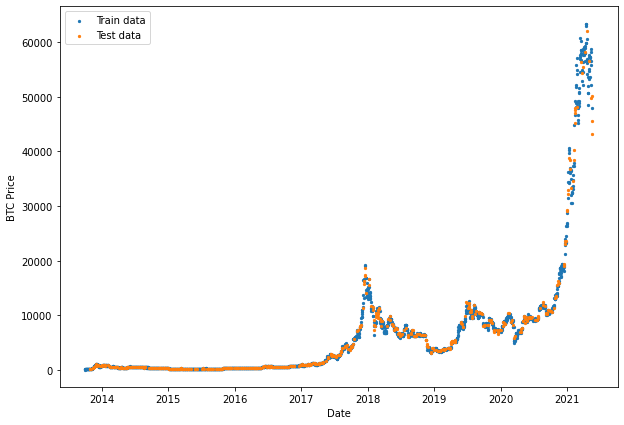

In [13]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

### Create train & test sets for time series (the right way)

In [14]:
# Create train and test splits for timeseries data the right way
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

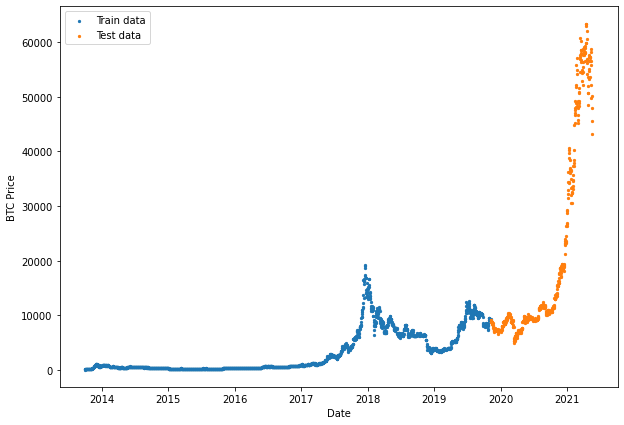

In [15]:
# Let's plot correct train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

## Create a plotting function

Typing ploting code is tedious, let's functionize it...

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of ploe, default = "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

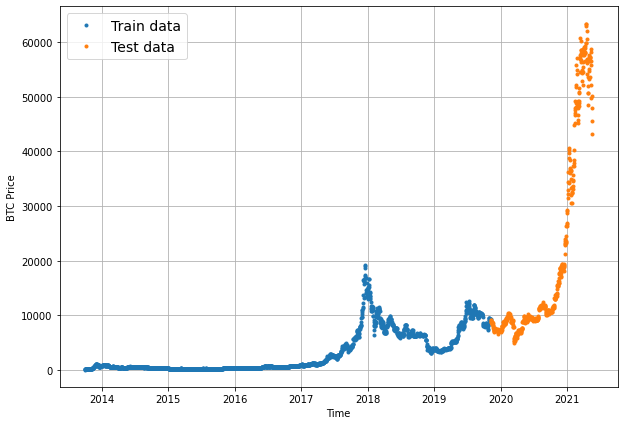

In [17]:
# Test our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon:** Number of timesteps into the future we're going to predict
* **Window size:** Number of timesteps we're going to use to predict *horizon*

Modelling experiments, we're running...

Model Number | Model Type | Horizon size | Window size | Extra data
------------ | ---------- | ------------ | ----------- | ----------
0 | Naïve model (baseline) | NA | NA | NA
1 | Dense model | 1 | 7 | NA
2 | Same architecture as 1 | 1 | 30 | NA
3 | Same architecture as 1 | 7 | 30 | NA
4 | Conv1D | 1 | 7 | NA
5 | LSTM | 1 | 7 | NA
6 | Same as architecture 1 (but with multivariate data) | 1 | 7 | Block reward size
7 | N-BEATs Algorithm | 1 | 7 | NA
8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA
9 | Future prediction model (model to predict future values) | 1 | 7 | NA
10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA

## Model 0: Naïve forecast (Baseline)

The formula looks like:
$$\hat{y}_{t} = y_{t-1}$$

In layman's terms:

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (previous timestep) - this is for a horizon of 1.

In [18]:
# Create a naïve forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

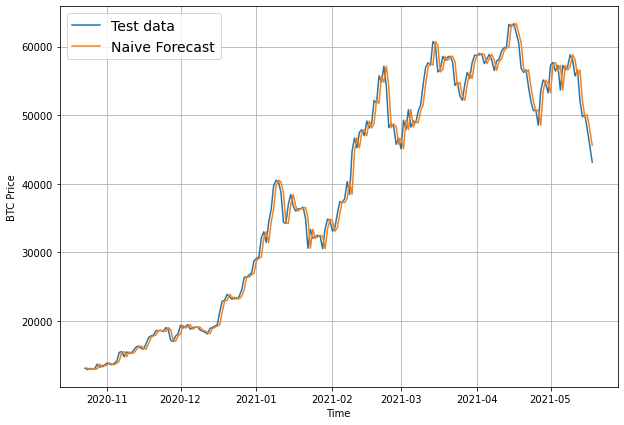

In [19]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, start=350, format="-", label="Test data")
plot_time_series(X_test[1:], naive_forecast, start=350, format="-", label="Naive Forecast")

 >  🛠 **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. And have a search to find out why the naïve forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a numbers, so that means we have a form of regression problem.

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* MAPE/sMAPE - (Symmetric) Mean Absolute Percentage Error
* MASE - Mean Absolute Scaled Error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is **how does our model's forecasts (y_pred) compare against the actual values (y_true/ground truth values)**? 

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [20]:
import tensorflow as tf

The formula for MASE is:

$$
q_{j} = \frac{e_{j}} {\frac{1} {T - 1}\sum_{t=2}^{T} \mid {y_{t} - y_{t - 1}}\mid}
$$

$$
MASE = mean(\mid q_{j} \mid) 
$$

In [21]:
# MASE Implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [23]:
# Create a function to take in model predictions and truth values and return various evaluation metrics
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

Let's now see if it works...

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [25]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

In [26]:
# Find minimum and maximum prices of Bitcoin in test dataset
tf.reduce_min(y_test).numpy(), tf.reduce_max(y_test).numpy()

(4944.7023359837, 63346.7890351052)

## Other models you can use for baslines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: 

Model/Library Name | Resource
------------------ | --------
Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime
TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests
Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats
LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our timeseries dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [27]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

In [28]:
# What we want to with our bitcoin data?
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [29]:
# Let's setup global variables for window size and horizon
HORIZON = 1     # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [30]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [31]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window)} -> Label: {tf.squeeze(test_label)}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our time series.

We could do this with Python for loops, however, for large time series, that would be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#).

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function we're about to create has been adapted from this [article](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [32]:
import numpy as np

# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windoes of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T    # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a timeseries) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [33]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [34]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon: [125.96116]


In [35]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i - 3]} -> Horizon: {full_labels[i - 3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Horizon: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Horizon: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Horizon: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array), an extension could be to try and replicate what we've done using the premade function.

## Turning windows into training and test sets

In [36]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))   # this will default to 80% train / 20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [38]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [40]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following:
[`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [41]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              monitor="val_loss",
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previosly we've used 32)
* 100 epochs

----------
* **Hyperparameters:** values a machine learning practitioner can adjust themselves
* **Parameters:** values a model learns on it's own

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_1_dense")    # name our model so we can save it

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [43]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [44]:
# Load in the saved best performing model_1 and evaluate it on test data
from tensorflow.keras.models import load_model

model_1 = load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Takes in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [45]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [46]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [47]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [48]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [49]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

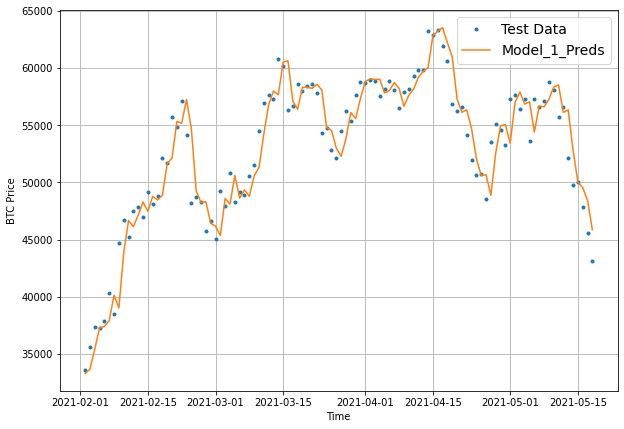

In [50]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 start=offset,
                 format="-", 
                 label="Model_1_Preds")

## Model 2: Dense (window = 30, horizon = 1)

In [51]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30    # use 30 timesteps in past

In [52]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [53]:
# Make train an testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [54]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_2 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_2_dense")    # name our model so we can save it

# 2. Compile the model
model_2.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_2 = model_2.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [56]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 659.3332 - mae: 659.3332 - mse: 1397247.7500


[659.3331909179688, 659.3331909179688, 1397247.75]

In [57]:
# Load in the best performing model
model_2 = load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

In [58]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [59]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mape': 2.726445,
 'mase': 1.0590738,
 'mse': 1273360.8,
 'rmse': 1128.4329}

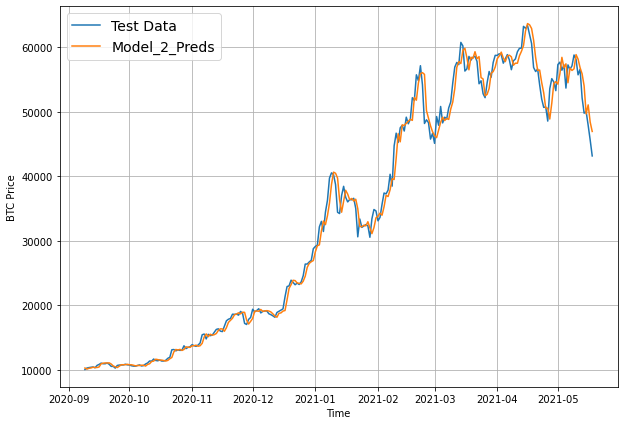

In [60]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model_2_Preds")

## Model 3: Dense (window = 30, horizon = 7)

In [61]:
HORIZON = 7 # predict one step at a time (one week of Bitcoin prices)
WINDOW_SIZE = 30    # use 30 timesteps in past

In [62]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [63]:
# Make train an testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [64]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_3 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_3_dense")    # name our model so we can save it

# 2. Compile the model
model_3.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_3 = model_3.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [66]:
# Evaluate model 3 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525 - mae: 1300.1525 - mse: 5599956.5000


[1300.1524658203125, 1300.1524658203125, 5599956.5]

In [67]:
# Load in the best performing model
model_3 = load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

In [68]:
# Get the forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [69]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

## Make our evaluation function work for larger horizons

In [70]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [71]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5065,
 'mape': 5.558879,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7478}

We've made and evaluated predictions with `model_3`, let's visualize it!

In [72]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
       9357.3545], dtype=float32)>

In [73]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9306.821>

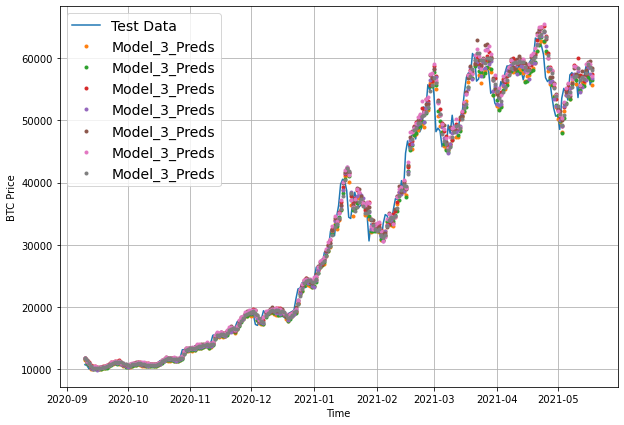

In [74]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="Model_3_Preds")

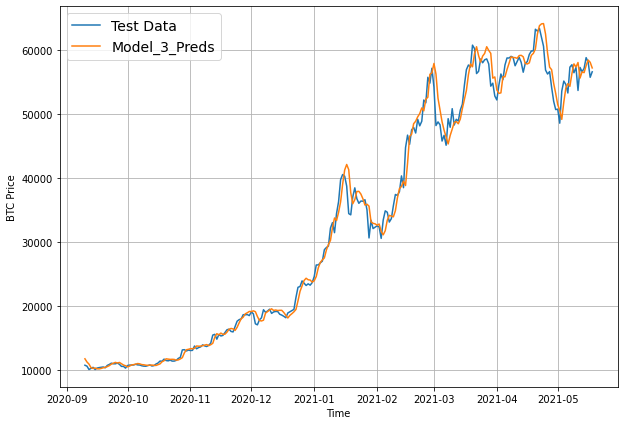

In [75]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset,
                 format="-",
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="Model_3_Preds")

## Which of our models is performing best so far?

So we've trained a few models, now let's compaare them and see how they've gone...

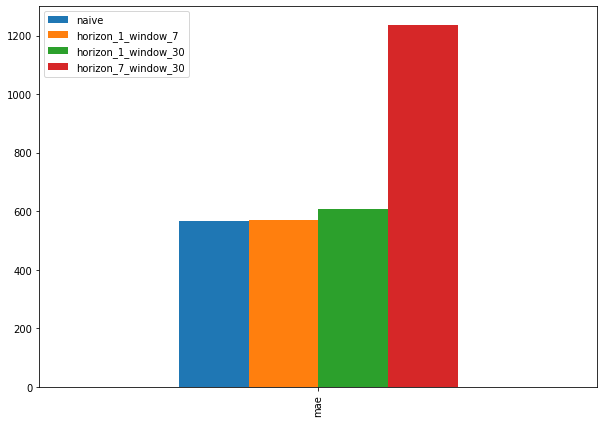

In [76]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t + 1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

## Model 4: Conv1D

In [77]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [78]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [79]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [80]:
# Chech data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [81]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [82]:
from tensorflow.keras.layers import Lambda
expand_dims_layer = Lambda(lambda x : tf.expand_dims(x, axis=1))    # add an extra dimension for `input_dim`

In [83]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # (WINDOW_SIZE, 1)
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [84]:
from tensorflow.keras.layers import Conv1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

tf.random.set_seed(42)

# Create Conv1D
model_4 = Sequential([
    Lambda(lambda x : tf.expand_dims(x, axis=1)),
    Conv1D(filters=128, 
           kernel_size=7,
           strides=1,
           padding="causal",
           activation="relu"),
    Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=Adam())

# Fit the model
history_model_4 = model_4.fit(train_windows,
                              train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [85]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Evaluate model...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 615.6102


615.6101684570312

In [87]:
# Load back in best performing Conv1D model
model_4 = load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.7388


570.73876953125

In [88]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8893.429, 8788.89 , 9020.29 , 8796.402, 8743.089, 8764.085,
       8680.323, 8538.849, 8475.116, 8526.651], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mape': 2.5461204,
 'mase': 1.00263,
 'mse': 1183499.9,
 'rmse': 1087.8878}

## Model 5: RNN (LSTM)

Let's build an RNN model for time series data.

We can use the same data we created for Conv1D model.

In [94]:
from tensorflow.keras.layers import LSTM, Lambda, Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
# x = LSTM(128, return_sequences=True, activation="relu")(x)
x = LSTM(128, activation="relu")(x)
# x = Dense(32, activation="relu")(x)
output = Dense(HORIZON, activation="linear")(x)
model_5 = Model(inputs, output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=Adam())

# Fit the model
history_model_5 = model_5.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2544.1982 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 109ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 989.3721 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 270.4985INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 196.5330INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 170.0374INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 136ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
10/18 [===============>..............] - ETA: 0s - loss: 186.3920INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
10/18 [===============>..............] - ETA: 0s - loss: 162.4181INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 162.3369 - val_loss: 877.1690
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 166.4726 - val_loss: 934.8436
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 163.9537 - val_loss: 920.2160
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 148.5054INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 122ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 147.4420 - val_loss: 898.9914
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 151.0533 - val_loss: 943.1418
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 157.8232 - val_loss: 924.0046
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9198 - val_loss: 911.4753
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 155.6456 - val_loss: 862.6680
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 153.1514 - val_loss: 862.5831
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 151.4883 - val_loss: 863.8172
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 150.7770 - val_loss: 886.8356
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 1

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 146.8467 - val_loss: 845.2782
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 145.1898INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 150.8635INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 144.4289 - val_loss: 804.3279
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 142.2844INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 142.4610 - val_loss: 789.0859
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 141.8739 - val_loss: 806.6758
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 142.0521 - val_loss: 794.8836
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 138.5929INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 138.4690 - val_loss: 773.2812
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 139.7511INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 135.9342 - val_loss: 786.4805
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 142.0684INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 133.4513 - val_loss: 756.2970
Epoch 36/100
12/18 [===================>..........] - ETA: 0s - loss: 132.2655INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 130.6932 - val_loss: 745.9099
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 138.3565INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6088 - val_loss: 719.0665
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6111 - val_loss: 732.0632
Epoch 41/100
10/18 [===============>..............] - ETA: 0s - loss: 133.3553INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
10/18 [===============>..............] - ETA: 0s - loss: 121.0014INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 106ms/step - loss: 125.6113 - val_loss: 700.8702
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 125.9959 - val_loss: 704.3682
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 124.8729INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 125.2241 - val_loss: 698.7766
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 121.2221INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 124ms/step - loss: 122.5007 - val_loss: 683.0590
Epoch 46/100
11/18 [=================>............] - ETA: 0s - loss: 130.6197INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 124.4726 - val_loss: 679.1873
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 122.1862 - val_loss: 705.4241
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 119.4245INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 122.0458 - val_loss: 677.0784
Epoch 49/100
11/18 [=================>............] - ETA: 0s - loss: 127.1128INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 121.1548 - val_loss: 674.6848
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8890 - val_loss: 691.4816
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 122.2994 - val_loss: 737.3929
Epoch 52/100
10/18 [===============>..............] - ETA: 0s - loss: 126.4967INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 132ms/step - loss: 121.2944 - val_loss: 657.2365
Epoch 53/100
10/18 [===============>..............] - ETA: 0s - loss: 114.9636INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 119.7668 - val_loss: 652.7970
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.1222 - val_loss: 654.4439
Epoch 55/100
11/18 [=================>............] - ETA: 0s - loss: 127.3472INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 119.2566 - val_loss: 647.2831
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 122.4764INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 120.0544 - val_loss: 643.7808
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1243 - val_loss: 671.1797
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 118.0024INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 124ms/step - loss: 118.4059 - val_loss: 640.2656
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 117.7119 - val_loss: 645.3837
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 119.2167INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 118.5346 - val_loss: 638.7429
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3129 - val_loss: 689.4144
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4350 - val_loss: 748.5565
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 123.1006 - val_loss: 651.8298
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 115.9679 - val_loss: 672.9166
Epoch 65/100
12/18 [===================>..........] - ETA: 0s - loss: 120.4224INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 118.8341 - val_loss: 631.7538
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2212 - val_loss: 634.5445
Epoch 67/100
11/18 [=================>............] - ETA: 0s - loss: 116.1731INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 116.1580 - val_loss: 623.8932
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5543 - val_loss: 635.4929
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5866 - val_loss: 626.3387
Epoch 70/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8156INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 123ms/step - loss: 114.9188 - val_loss: 619.3181
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - val_loss: 650.9373
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 118.2033 - val_loss: 630.5287
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 115.3612 - val_loss: 623.0369
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0345 - val_loss: 623.0776
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2057 - val_loss: 640.5281
Epoch 76/100
10/18 [===============>..............] - ETA: 0s - loss: 116.2252INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 114.1402 - val_loss: 614.4062
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5973 - val_loss: 689.8776
Epoch 78/100
18/18 [==============================] - 0s 8ms/step - loss: 117.2611 - val_loss: 645.2790
Epoch 79/100
12/18 [===================>..........] - ETA: 0s - loss: 112.1790INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 114.1995 - val_loss: 608.7159
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7125 - val_loss: 614.9222
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3684 - val_loss: 634.8466
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 122.9989INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 115.9701 - val_loss: 607.8510
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3599 - val_loss: 628.8181
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4113 - val_loss: 628.5579
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8363 - val_loss: 634.7715
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5462 - val_loss: 613.5223
Epoch 87/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3621INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 112.5059 - val_loss: 604.7603
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 114.8154INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 111.7706 - val_loss: 601.5748
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8470 - val_loss: 624.0131
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6354 - val_loss: 662.9452
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 116.1836 - val_loss: 636.0310
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1700 - val_loss: 606.0366
Epoch 93/100
10/18 [===============>..............] - ETA: 0s - loss: 111.9717INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 112.4748 - val_loss: 599.8319
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2637 - val_loss: 601.3256
Epoch 95/100
11/18 [=================>............] - ETA: 0s - loss: 106.7242INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 111.0185 - val_loss: 597.1485
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3787 - val_loss: 601.1596
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - val_loss: 626.1573
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7326 - val_loss: 601.0142
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 109.1518INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 110.7480 - val_loss: 594.6030
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - val_loss: 595.9847


In [95]:
# Load in best version of model 5 and evaluate on the test data
model_5 = load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 594.6030


594.6029663085938

In [96]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8978.46 , 8810.951, 8997.779, 8836.308, 8731.047], dtype=float32)>

In [97]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mape': 2.6717565,
 'mase': 1.0445527,
 'mse': 1267231.9,
 'rmse': 1125.7139}

In [99]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used almost for any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.